In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [ ]:
%ls

 Balanced_I_hotel_dataset_final.ipynb     optuna_test/
 Balanced_II_hotel_dataset_final.ipynb    output/
 booking_time_final_original/             output_other_dataset/
 Business_hotel_dataset_final.ipynb       Preprocess_data_dunnhumby.ipynb
 clustered_test.pkl                       Preprocess_data_full_hotel_dataset_final.ipynb
 copy_optuna_test/                        price_tft/
 data_analysis/                           RandomForestRegressor_final_dunnhumby.ipynb
 Leisure_hotel_dataset_final.ipynb        RandomForestRegressor_final.ipynb
 LSTM_final_dunnhumby_FINAL.ipynb        'Readme file.gdoc'
 LSTM_next_final_ablation.ipynb           TFT_creation_to_creation_final.ipynb
 LSTM_next_final.ipynb                    tft.pkl
 LSTM_next_final_no_lstm_ablation.ipynb   TFT_target_price_final.ipynb
 LSTM_stop_final_ablation.ipynb           Trained_models/
 LSTM_stop_final.ipynb                    Transformer_encoder_final.ipynb
 LSTM_stop_final_lstm_ablation.ipynb


imported libraries

In [ ]:
!pip install pytorch_forecasting
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_ext

In [ ]:
import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np
import lightning.pytorch as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting.data import GroupNormalizer

from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.cluster import DBSCAN

from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.metrics import mean_absolute_error

To ignore warnings:


In [ ]:
import warnings
warnings.filterwarnings('ignore')

open data file

In [ ]:
df_all_hotels = pd.DataFrame()
path = 'output/9_data_within_timeframe_updated/'
filenames = [file for file in os.listdir(path) if file.endswith('.feather')]
for i in filenames:
  df_hotel = pd.read_feather(path + i)
  df_hotel["price_p_night"] = df_hotel["price"]/df_hotel["nights"]
  df_all_hotels = pd.concat([df_all_hotels, df_hotel])

**Prepare arrival to new creation date column**

# **Working TFT for the target variable price**

**Create grouped object per hotel per week and select relevant columns**

In [ ]:
def group_weekly_and_process(df_hotels):
  df_all_hotels = df_hotels.astype({"price": float, "lodging": float, "beauty": float, "beauty": float, "extras": float, "restaurant" : float})#, "week" : float, "month" : float})
  hotels_week_grouped = df_all_hotels.groupby(["hotel_name", pd.Grouper(key="arrival", freq = "M")])
  df_all_hotels_week = hotels_week_grouped.sum()
  relevant_cols = ['nights',
          'adults', 'lodging', 'beauty', 'extras', 'price', 'rooms',
        'kids']
  df_all_hotels_week = df_all_hotels_week[relevant_cols]
  df_all_hotels_week["proportion_vacation"] = hotels_week_grouped.sum()['vacation_arrival_date'] / hotels_week_grouped.count()["index"]
  df_all_hotels_week["proportion_holiday"] = hotels_week_grouped.sum()['holiday_arrival_date'] / hotels_week_grouped.count()["index"]
  df_all_hotels_week["proportion_weekend"] = hotels_week_grouped.sum()['weekend_arrival_date'] / hotels_week_grouped.count()["index"]
  return df_all_hotels_week

In [ ]:
df_all_hotels_week = group_weekly_and_process(df_all_hotels)

<ipython-input-10-4b904c8620b3>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all_hotels_week = hotels_week_grouped.sum()
<ipython-input-10-4b904c8620b3>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all_hotels_week["proportion_vacation"] = hotels_week_grouped.sum()['vacation_arrival_date'] / hotels_week_grouped.count()["index"]
<ipython-input-10-4b904c8620b3>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
 

**Add rows for missing dates, such that all hotels in df have a row for every week between minimum and maximum date**

In [ ]:
def add_rows_missing_dates(df_all_hotels_week):
  min_date, max_date = df_all_hotels_week.index.get_level_values(1).min(), df_all_hotels_week.index.get_level_values(1).max()
  total_date_range = pd.date_range(min_date,max_date,freq='m')
  hotels_indices = df_all_hotels_week.index.get_level_values(0).unique()
  result = df_all_hotels_week.copy()
  for h in hotels_indices:
    missing_dates = list(set(total_date_range) - set(df_all_hotels_week.loc[h,:].index))
    missing_rows = pd.DataFrame(0, index=missing_dates, columns=df_all_hotels_week.columns)
    missing_rows_indexed = pd.concat({h: missing_rows}, names=['hotel_name'])
    result = pd.concat([result, missing_rows_indexed])
  return result.sort_index()


In [ ]:
df_all_hotels_week_imputed = add_rows_missing_dates(df_all_hotels_week)

**Add a time index, unique per hotel**

In [ ]:
def create_df_time_index(df):
  min_date, max_date = df.index.get_level_values(1).min(), df.index.get_level_values(1).max()
  df_time_index = pd.DataFrame(1, index=pd.date_range(min_date,max_date,freq='m'), columns=['time_index']).cumsum()
  return df_time_index

In [ ]:
def add_time_idx_col(df):
  time_idx = create_df_time_index(df)
  print(time_idx)
  df['time_index'] = df.apply(lambda x: time_idx.loc[x.name[1]], axis=1)
  return df

df_weekly_time_idx = add_time_idx_col(df_all_hotels_week_imputed)
#df_weekly_time_idx[df_weekly_time_idx['time_index'] < 10]


            time_index
2012-01-31           1
2012-02-29           2
2012-03-31           3
2012-04-30           4
2012-05-31           5
...                ...
2019-03-31          87
2019-04-30          88
2019-05-31          89
2019-06-30          90
2019-07-31          91

[91 rows x 1 columns]


In [ ]:
def add_month_week_number(df):
  df['month_number'] = df.apply(lambda x: x.name[1].month, axis=1)
  df['week_number'] = df.apply(lambda x: x.name[1].week, axis=1)
  return df

df_weekly_tft = add_month_week_number(df_weekly_time_idx)

# Reset the index for tft:
df_weekly_tft = df_weekly_tft.reset_index()

## Create time series dataset

*Do need to check if relevant columns were included and parameters were chosen right.*

In [ ]:
used_columns = ['hotel_name', 'nights', 'adults', 'lodging', 'beauty',
       'extras', 'price', 'rooms', 'kids',
       'proportion_vacation', 'proportion_holiday', 'time_index',
       'month_number', 'week_number', "proportion_weekend"]
df_weekly_tft = df_weekly_tft[used_columns]

In [ ]:
max_prediction_length = 24
max_encoder_length = 48
# training_cutoff = df_weekly_tft["time_index"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_weekly_tft,
    time_idx="time_index",
    target="price",
    group_ids=["hotel_name"],
    # min_encoder_length = 1,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["hotel_name"],
    # static_reals=["birthday"],# embeddings e.g.
    # time_varying_known_categoricals=["month_number", "week_number"], #This part is either belong to this variable or variable time_varying_known_reals
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['time_index', 'month_number', 'week_number'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals= ['nights', 'adults', 'lodging', 'beauty', 'extras', 'price', 'rooms',
       'kids','proportion_vacation',
       'proportion_holiday', "proportion_weekend"
    ],
    # target_normalizer=GroupNormalizer(
        # groups=["state"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    # categorical_encoders = {'hotel_name': NaNLabelEncoder(add_nan=True)}
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_weekly_tft, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 256  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
import tensorflow as tf
import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


# tensorboard.compat.tensorflow_stub.io.gfile'

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 29.9k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="price_tft_final",
    n_trials=10,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.01, 0.3),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-10-18 15:58:54,581] A new study created in memory with name: no-name-e2d7091d-fafc-47fd-9de2-37a4be862976
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
[I 2023-10-18 16:05:23,960] Trial 0 finished with value: 14127.1904296875 and parameters: {'gradient_clip_val': 0.5434166581347324, 'hidden_size': 116, 'dropout': 0.20655411312848335, 'hidden_continuous_size': 56, 'attention_head_size': 3, 'learning_rate': 0.01318959587644149}. Best is trial 0 with value: 14127.1904296875.
INFO:pytorch_li

In [ ]:
best_tft = TemporalFusionTransformer.load_from_checkpoint("price_tft/trial_9/epoch=19.ckpt")
print(best_tft)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TemporalFusionTransformer(
  	"attention_head_size":               3
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.2947678179157454
  	"embedding_labels":                  {'hotel_name': {'aktivhotel-waldhof': 0, 'alfa-soleil': 1, 'almdorf-reiteralm': 2, 'alpina-dolomites': 3, 'alpinhotel-post': 4, 'ansitz-steinbock': 5, 'bad-schoergau': 6, 'baerenhotel': 7, 'bergblick': 8, 'chesa-mulin': 9, 'chesapool': 10, 'dermuth': 11, 'dolcevita-jagdhof': 12, 'dorfplatzl': 13, 'dreikoenigshof': 14, 'edelweiss-obertauern': 15, 'engel': 16, 'erhart': 17, 'familienhotel-post': 18, 'forsthofalm': 19, 'ganischgerhof': 20, 'gaspingerhof': 21, 'gasthofzurpost': 22, 'granpanorama-stephanshof': 23, 'gutenberg': 24, 'helvetia': 25, 'hirschen': 26, 'hoisnwirt': 27, 'huettenhof': 28, 'jagdhof': 29, 'kaprunerhof': 30, 'lue': 31, 'manggei': 32, 'masl': 33, 'matillhof': 34, 'moserhof': 35, 'nesslerhof': 36, 'novakoeflach': 37, 'p

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
labels_list =[]
for label in raw_predictions.x["decoder_target"]:
  labels_list.append(label.cpu().numpy())

In [ ]:
prediction_list = []
for prediction in raw_predictions.output[0]:
  prediction_list.append(prediction.cpu().numpy())

In [ ]:
p_list = []
l_list = []
for i in range(len(labels_list)):
  prediction = prediction_list[i]
  label = labels_list[i]
  # print(prediction)
  for j in range(len(prediction)):
    p = prediction[j][3]
    l = label[j]
    p_list.append(p)
    l_list.append(l)

In [ ]:
np.sqrt(mean_squared_error(l_list, p_list))

144207.28

In [ ]:

mean_absolute_error(l_list, p_list)

47918.793

In [ ]:
for idx in range(40):  # this number is the amount of hotels it has predicted of
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
indices

tensor([12,  1, 38, 49, 25, 10, 44,  5, 55, 31, 22,  9, 19, 45, 41, 14, 26, 53,
        42, 32, 15, 17, 52, 35, 13, 27,  6, 48, 11, 34, 21, 37, 43, 46, 51, 40,
         0,  7, 56, 59,  4, 47, 30, 39, 16, 20, 54, 58,  8, 24, 50, 36, 57, 28,
        33, 23,  3, 18, 29,  2], device='cuda:0')

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserW

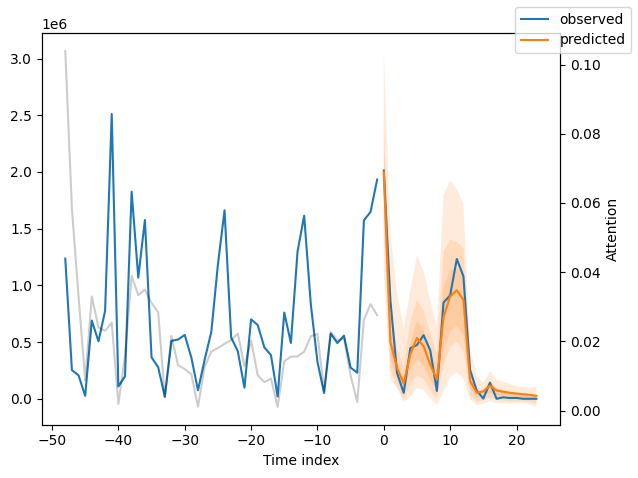

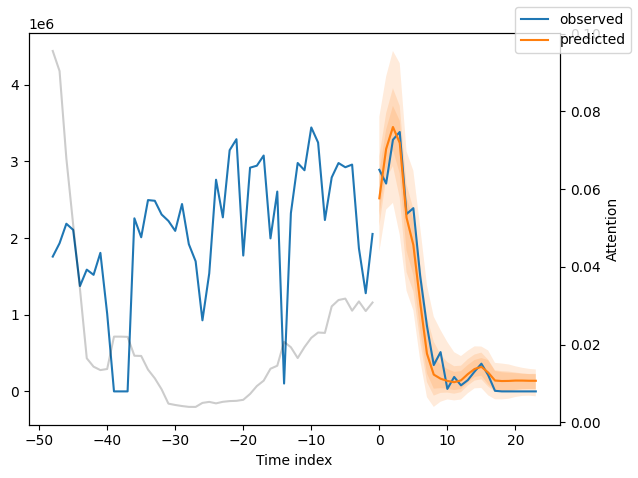

In [ ]:
# calculate metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(2):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx]
    )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


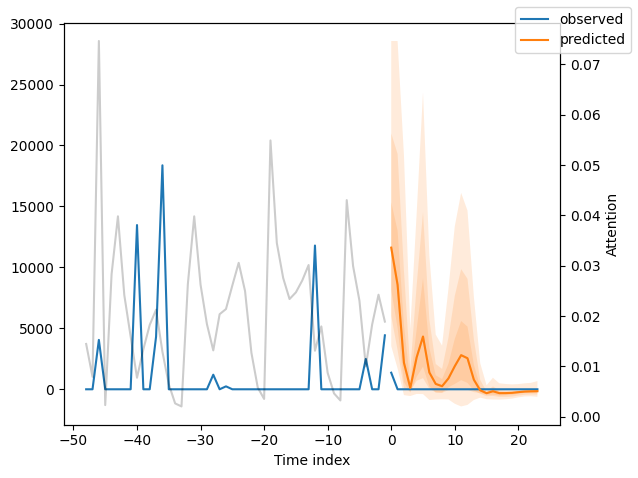

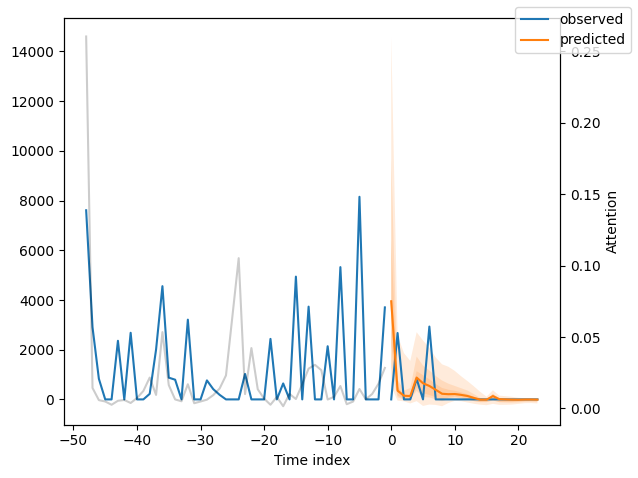

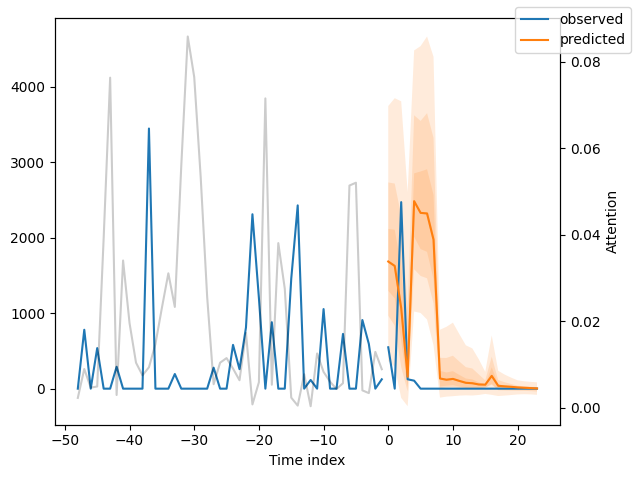

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(3):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
    )

In [ ]:
predictions = tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

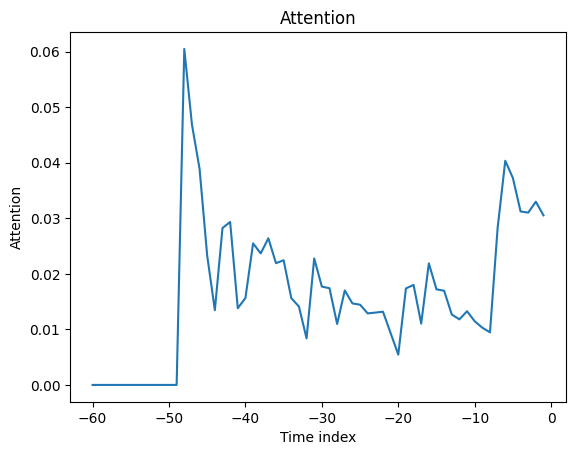

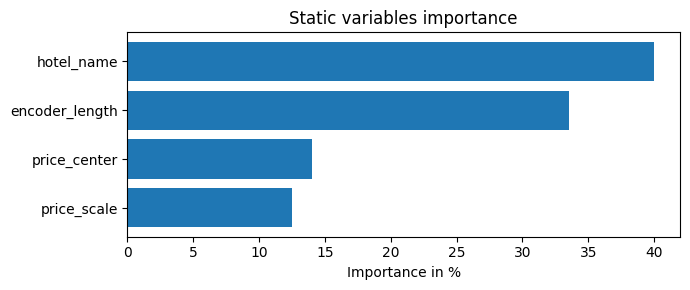

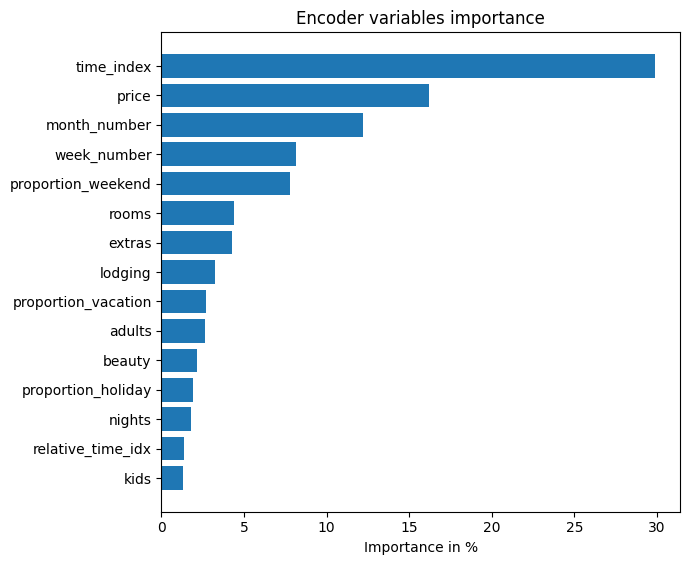

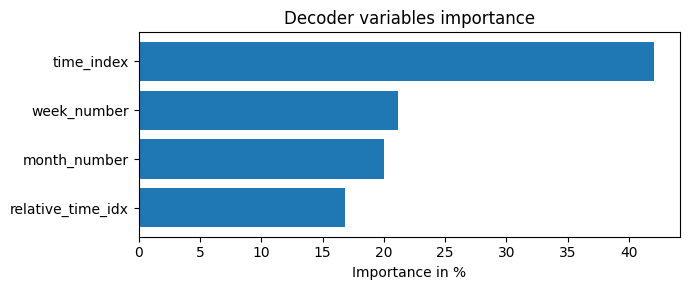

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)